# Importing torch and other libraries

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

device = ("cuda" if torch.cuda.is_available() else "cpu")

# Load data

In [2]:
def load_data(data_path):
    def sparse_to_dense(sparse_r_d, vocab_size):
        """
        Convert a sparse representation of a document by tf-idf to dense form
        by mapping its word to a new vector of vocabulary size.
        Word without any appearance in the doc get the value 0.0
        """
        r_d = [0.0 for _ in range(vocab_size)]
        indices_tf_idfs = sparse_r_d.split()
        for index_tf_idf in indices_tf_idfs:
            index = int(index_tf_idf.split(":")[0])
            tfidf = float(index_tf_idf.split(":")[1])
            r_d[index] = tfidf
        return np.array(r_d)
    with open(data_path) as f:
        d_lines = f.read().splitlines()
    with open("/Users/anhoang/Desktop/devzone/DS_project/words_idfs_final.txt") as f:
        vocab_size = len(f.read().splitlines())

    X = []
    Y = []
    # label_count = defaultdict(int)
    for data_id, d in enumerate(d_lines):
        features = d.split("<fff>")
        label, doc_id = int(features[0]), int(features[1])
        # label_count[label] += 1
        r_d = sparse_to_dense(
            sparse_r_d=features[2], vocab_size=vocab_size)
        X.append(r_d)
        one_hot_label = np.zeros((6), dtype=int)
        one_hot_label[label] = 1
        Y.append(one_hot_label)
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

In [3]:
X, Y = load_data(data_path="data_tf_idf_final.txt")

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)

In [11]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
Y_train = torch.from_numpy(Y_train.squeeze())
Y_test = torch.from_numpy(Y_test.squeeze())

# Build the model

In [12]:
class MLP(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super().__init__()
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        self.fc1 = nn.Linear(input_num, hidden_num) # hidden layer
        self.fc2 = nn.Linear(hidden_num, output_num) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid activation function
        self.relu = nn.ReLU() # relu activation function
        self.softmax = nn.Softmax(dim = 1) # softmax activation function
    
    def forward(self, x):
        x = self.relu(self.fc1(x)) 
        x = self.softmax(self.fc2(x))
        return x
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self(x)
            predicted_labels = torch.argmax(output, dim=1)
            one_hot = torch.zeros_like(output)
            one_hot.scatter_(1, predicted_labels.unsqueeze(1), 1)
            return one_hot.tolist()


In [13]:
with open("words_idfs_final.txt") as f:
        vocab_size = len(f.read().splitlines())

input_num = vocab_size
hidden_num = 50
output_num = 6 # The output should be the same as the number of classes

model = MLP(input_num, hidden_num, output_num)
model.to(device)
print(model)
     

MLP(
  (fc1): Linear(in_features=8967, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=6, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [15]:
num_epochs = 200 # num of epochs
train_accuracy_lst = []
test_accuracy_lst = []

for epoch in range(num_epochs):
    # forward propagation
    Y_pred = model(X_train)
    loss = criterion(Y_pred, Y_train)
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_prediction = model.predict(X_train)
    train_accuracy_lst.append(accuracy_score(model_prediction, Y_train) * 100)
    
    model_prediction = model.predict(X_test)
    test_accuracy_lst.append(accuracy_score(model_prediction, Y_test) * 100)

    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch, num_epochs, loss.item()))
print('\nTraining Complete')

Epoch [0/200], Loss: 1.79183
Epoch [10/200], Loss: 1.78510
Epoch [20/200], Loss: 1.77388
Epoch [30/200], Loss: 1.75715
Epoch [40/200], Loss: 1.73539
Epoch [50/200], Loss: 1.71339
Epoch [60/200], Loss: 1.69298
Epoch [70/200], Loss: 1.67309
Epoch [80/200], Loss: 1.65188
Epoch [90/200], Loss: 1.62848
Epoch [100/200], Loss: 1.60322
Epoch [110/200], Loss: 1.57722
Epoch [120/200], Loss: 1.55147
Epoch [130/200], Loss: 1.52651
Epoch [140/200], Loss: 1.50241
Epoch [150/200], Loss: 1.47909
Epoch [160/200], Loss: 1.45661
Epoch [170/200], Loss: 1.43521
Epoch [180/200], Loss: 1.41509
Epoch [190/200], Loss: 1.39640

Training Complete


In [30]:
model_prediction = model.predict(X_test)

In [17]:
print("Accuracy Score on test data ==>> {}%".format(accuracy_score(model_prediction, Y_test) * 100))

Accuracy Score on test data ==>> 54.69518190757129%


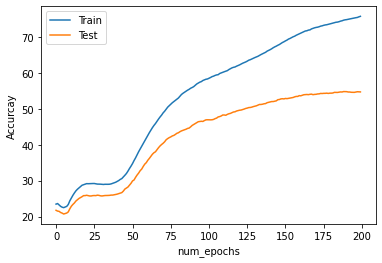

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_epochs), train_accuracy_lst)
ax.plot(np.arange(num_epochs), test_accuracy_lst)
ax.set_xlabel("num_epochs")
ax.set_ylabel("Accurcay")
# ax.set_title("Tuning C parameter in SVM model")
ax.legend(["Train", "Test"])
plt.show()

In [20]:
print(max(test_accuracy_lst))
print(test_accuracy_lst[130:170])

54.793510324483776
[50.71288102261554, 50.835791543756145, 51.007866273352995, 51.20452310717798, 51.20452310717798, 51.27826941986234, 51.40117994100295, 51.45034414945919, 51.69616519174042, 51.7944936086529, 51.89282202556539, 52.015732546706, 52.015732546706, 52.11406096361848, 52.21238938053098, 52.53195673549656, 52.5811209439528, 52.753195673549655, 52.8023598820059, 52.753195673549655, 52.876106194690266, 52.82694198623402, 52.90068829891838, 52.94985250737463, 53.07276302851525, 53.14650934119961, 53.31858407079646, 53.441494591937065, 53.441494591937065, 53.66273352999017, 53.61356932153393, 53.76106194690266, 53.908554572271385, 53.9331366764995, 53.98230088495575, 53.9331366764995, 54.031465093412, 54.08062930186824, 53.9331366764995, 54.00688298918387]


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
genresgroup_list = ['COUNTRY', 'HIPHOP', 'INDIE', 'JAZZ', 'POP', 'ROCK']

In [22]:
def show_confusion_matrix(confusion_matrix):
    plt.rcParams["figure.figsize"] = (10,7)
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(genresgroup_list, rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(genresgroup_list, rotation=30, ha='right')
    plt.ylabel('True category')
    plt.xlabel('Predicted category');

In [35]:
Y_pred_index = np.argmax(model_prediction, axis = 1)

In [36]:
Y_test_index = np.argmax(Y_test.cpu(), axis = 1)

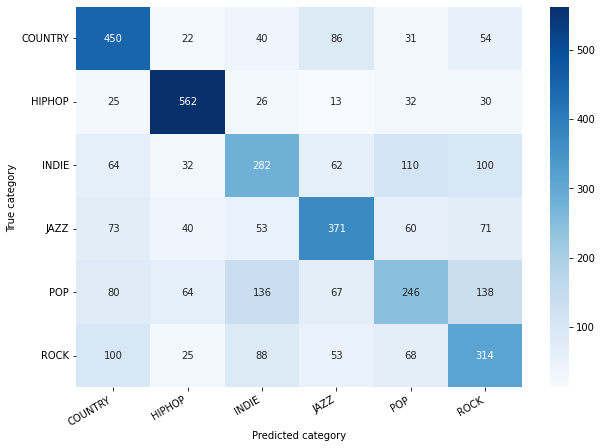

In [34]:
cfm = confusion_matrix(Y_test_index, Y_pred_index)
show_confusion_matrix(cfm)


# Minibatch GD

Epoch [0/4], Loss: 1.10616
Epoch [1/4], Loss: 1.10624
Epoch [2/4], Loss: 1.10625
Epoch [3/4], Loss: 1.10189


In [84]:
model_prediction = model.predict(X_test)

In [85]:
print("Accuracy Score on test data ==>> {}%".format(accuracy_score(model_prediction, Y_test) * 100))

Accuracy Score on test data ==>> 44.72222222222222%
